In [1]:
pixel_x, pixel_y = 3222, 3220


In [2]:
import numpy as np
import os

def extract_pixel_values(folder_path, pixel_x, pixel_y):
    pixel_values = []
    for image_filename in sorted(os.listdir(folder_path)):
        image_path = os.path.join(folder_path, image_filename)
        if image_path.endswith('.npy'):  # Ensure the file is a .npy file
            image_array = np.load(image_path)  # Load the .npy file as an array
            pixel_value = image_array[pixel_y, pixel_x]  # Access the pixel value directly
            pixel_values.append(pixel_value)
    return pixel_values

# Paths to your folders
ndvi_folder = "C:/Users/Musae/Documents/GitHub-REPOs/Senior-project_Doc/Docs/Array/NDVI-Array"
savi_folder = "C:/Users/Musae/Documents/GitHub-REPOs/Senior-project_Doc/Docs/Array/SAVI-Array"
sdmi_folder = "C:/Users/Musae/Documents/GitHub-REPOs/Senior-project_Doc/Docs/Array/NDMI-Array"

# Extract pixel values for NDVI, SAVI, and SDMI
ndvi_pixel_values = extract_pixel_values(ndvi_folder, pixel_x, pixel_y)
savi_pixel_values = extract_pixel_values(savi_folder, pixel_x, pixel_y)
sdmi_pixel_values = extract_pixel_values(sdmi_folder, pixel_x, pixel_y)


In [3]:
# Assuming the extra NDVI, SAVI, SDMI values are at the end of the lists
ndvi_pixel_values = ndvi_pixel_values[:59]
savi_pixel_values = savi_pixel_values[:59]
sdmi_pixel_values = sdmi_pixel_values[:59]


In [4]:
import pandas as pd

# Load the CSV file
csv_file = "C:\\Users\\Musae\\Documents\\GitHub-REPOs\\Senior-project_Doc\\monthly_averages_formatted.csv"
climate_data = pd.read_csv(csv_file)

# Assuming your climate data is in the same time order and matches the images
temp_values = climate_data['Temp Average'].values.tolist()
precip_values = climate_data['PRECTOTCORR Average'].values.tolist()


In [5]:
# Combining all extracted values into a structured format
structured_data = {
    'NDVI': ndvi_pixel_values,
    'SAVI': savi_pixel_values,
    'SDMI': sdmi_pixel_values,
    'Temperature': temp_values,
    'Precipitation': precip_values
}

# Convert to DataFrame for easier manipulation and visualization
data_df = pd.DataFrame(structured_data)


In [6]:
structured_data

{'NDVI': [0.030472517,
  0.025283495,
  0.050978977,
  0.0366731,
  0.036097903,
  0.038910504,
  0.034763314,
  0.042933132,
  0.024447031,
  0.02657922,
  0.037225828,
  0.05403239,
  0.053077456,
  0.060820367,
  0.03430657,
  0.0243725,
  0.035078444,
  0.041989665,
  0.057206538,
  0.029034691,
  0.024767257,
  0.0367127,
  0.06166913,
  0.032639883,
  0.052328818,
  0.035510134,
  0.0396751,
  0.049763896,
  0.041862145,
  0.04411765,
  0.05324524,
  0.034741413,
  0.04270597,
  0.03205941,
  0.056728475,
  0.05021622,
  0.0441994,
  0.01513019,
  0.052887868,
  0.04153693,
  0.036221243,
  0.046465185,
  0.038336053,
  0.031123139,
  0.03650317,
  0.046213437,
  0.034030754,
  0.032992776,
  0.03084045,
  0.03349083,
  0.0500205,
  0.028660761,
  0.030546624,
  0.042167842,
  0.038646333,
  0.018496377,
  0.04800169,
  0.032890618,
  0.047338523],
 'SAVI': [0.04570437,
  0.037922055,
  0.07646157,
  0.055004824,
  0.05414209,
  0.05836008,
  0.05214015,
  0.06439358,
  0.0366669

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming 'data_df' is your DataFrame containing the features 'NDVI', 'SAVI', 'SDMI', 'Temperature', and 'Precipitation'
# Normalize the features using MinMaxScaler from scikit-learn

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data_df[['NDVI', 'SAVI', 'SDMI', 'Temperature', 'Precipitation']])

# Function to create sequences for LSTM input
def create_sequences(data, sequence_length=12):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # Create sequences of 12 months of features
        X.append(data[i:i + sequence_length])
        # The target is the NDVI value of the next month
        y.append(data[i + sequence_length, 0])  # Assuming NDVI is at index 0
    return np.array(X), np.array(y)

# Create sequences
sequence_length = 12  # Using 12 months of data to predict the NDVI of the next month
X, y = create_sequences(scaled_features, sequence_length)

# X and y are now ready for training an LSTM model
X.shape, y.shape


((47, 12, 5), (47,))

In [8]:
# Assuming you're reserving the last 12 sequences for testing
train_size = len(X) - 12

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, X.shape[2])),  # input_shape = (sequence_length, number of features)
    Dense(1)  # Predicting a single value
])
model.compile(optimizer='adam', loss='mse')


c:\Users\Musae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4161 - val_loss: 0.2413
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3919 - val_loss: 0.2224
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3684 - val_loss: 0.2037
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3451 - val_loss: 0.1850
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3219 - val_loss: 0.1667
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2988 - val_loss: 0.1483
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2760 - val_loss: 0.1302
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2534 - val_loss: 0.1125
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2309 - val_loss: 0.0956
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2086 - val_loss: 0.0796
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1868 - val_loss: 0.0647
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1657 - val_loss

In [11]:
# Evaluate the model
model.evaluate(X_test, y_test)

# Make predictions
predictions = model.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming 'predictions' is a numpy array with your model's predictions
# and 'y_test' is the true NDVI values for the test set

mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² score: {r2:.4f}")


MAE: 0.2054
RMSE: 0.2425
R² score: -0.6001


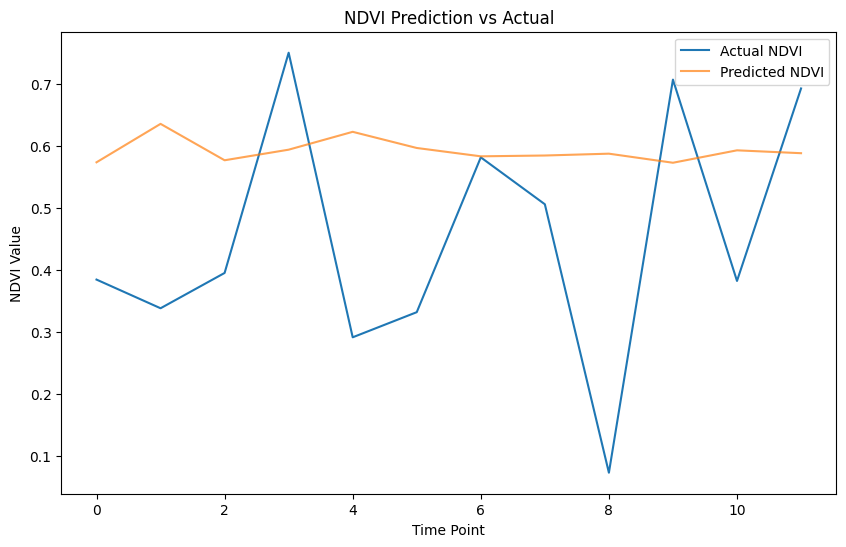

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual NDVI')
plt.plot(predictions, label='Predicted NDVI', alpha=0.7)
plt.title('NDVI Prediction vs Actual')
plt.xlabel('Time Point')
plt.ylabel('NDVI Value')
plt.legend()
plt.show()
